# **Multi-Label Text Classifier with DistilBERT**

## Objective:
The goal of this project is to build a multi-label text classifier that can accurately classify movie descriptions into multiple genres using a fine-tuned DistilBERT model. The dataset consists of movie descriptions and their associated genres, where each description can belong to multiple genres.






---

These two commands set up your environment for training models like DistilBERT and ensure that you are using the latest optimized versions of these libraries.

---



In [ ]:
!pip install -U accelerate
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0


In [ ]:
!pip install -U accelerate
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0


# **Importing the dataset of IMDB MOVIES DATA**

1. **Description**: Contains the text description of each movie, such as plot summaries or synopses.
2. **Genre**: Contains the genres associated with each movie, which may include multiple labels (e.g., Action, Drama, Comedy, etc.).

These are the two columns you will be working with in your dataset for tasks like multi-label classification.

In [ ]:
import pandas as pd
df = pd.read_csv("/content/IMDB-Movie-Data (1).csv", usecols=["Description", "Genre"])
df.head()

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...


## **Dataset Overview and Duplicate Analysis**

In [ ]:
print(df.shape)
print(df.info())
print(df.duplicated().sum())

(1000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genre        1000 non-null   object
 1   Description  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None
0


# **Distribution of Movie Description Lengths**
visualizes the distribution of the number of characters in the "Description" column


<Axes: ylabel='Frequency'>

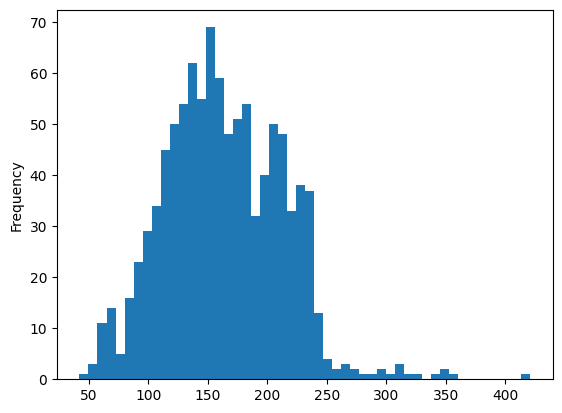

In [ ]:
df['Description'].str.len().plot.hist(bins=50)

## **Genre Counts in the Table**
This table displays the frequency of each genre in the dataset, showing the number of occurrences for each:

In [ ]:
df['Genre'] = df['Genre'].str.split(',')
genre_counts = [g for gen in df['Genre'] for g in gen]
pd.Series(genre_counts).value_counts()

,count
Drama,513
Action,303
Comedy,279
Adventure,259
Thriller,195
Crime,150
Romance,141
Sci-Fi,120
Horror,119
Mystery,106


## **Multi-Label Binarization and Text Extraction**
Transforms the genres into a multi-label format and extracts the movie descriptions:

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df['Genre']).astype("float32")

texts = df['Description'].tolist()



In [ ]:
labels

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
labels
texts[:5]

['A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.',
 'Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.',
 'Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.',
 "In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.",
 'A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.']

In [ ]:
multilabel.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'], dtype=object)

## **Library Imports for Multi-Label Classification Using DistilBERT**
imports the necessary libraries and modules for building, training, and evaluating a multi-label classification model using DistilBERT:


In [ ]:
import torch
import numpy as np
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction


## **Splitting Data into Training and Validation Sets**
splits the dataset into training and validation sets for model training and evaluation:

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2, random_state=42)

## **Loading the Pretrained DistilBERT Model  "distilbert-base-uncased"**
 Loads the DistilBERT tokenizer and model, configured for multi-label classification:

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]),
                                                            problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Custom Dataset Class for Multi-Label Text Classification**
Custom PyTorch dataset class for handling text data and their corresponding multi-labels:


In [ ]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }



## **Creating Custom Datasets for Training and Validation**

By creating these datasets, we prepare the training and validation data for batching and loading during model training, ensuring that the inputs are correctly tokenized and formatted for the DistilBERT model.

In [ ]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  2043, 15229, 11404, 15102,  1996,  5758,  1997,  2010, 13032,
         12943, 19231,  2906,  1998, 12154,  1996,  4813,  1997,  1037,  3040,
         12025,  1010,  2002,  9418,  2002,  2003,  1037, 12608,  1997,  1996,
          3595, 18364,  2554,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## **Custom Metrics for Multi-Label Classification Evaluation**
These functions provide a custom evaluation process for multi-label classification tasks, ensuring that the metrics calculated (F1 score, ROC AUC, Hamming Loss) are appropriate for multi-label outputs. This approach goes beyond standard single-label evaluation and is crucial for evaluating the performance of models handling multiple genres per movie description.

In [ ]:

def multi_labels_metrics(predictions, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

## **Training Setup with DistilBERT using HuggingFace Trainer**
The training arguments and sets up the Trainer from the HuggingFace transformers library to train the multi-label text classification model using DistilBERT.

In [ ]:
# Training Arguments
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=1e-5,
    output_dir = './results',
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## **Model Training**
The training process for the DistilBERT-based multi-label text classifier

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
1,0.507000,0.396999,0.509441,0.218000,0.112417,1.442900,138.609000,17.326000
2,0.365900,0.344026,0.508394,0.164000,0.093515,0.895300,223.391000,27.924000
3,0.327200,0.318654,0.535680,0.124250,0.124822,0.881800,226.803000,28.350000
4,0.305300,0.305487,0.535667,0.126250,0.127133,0.890300,224.638000,28.080000
5,0.291500,0.295130,0.551110,0.115750,0.143360,0.910800,219.585000,27.448000
6,0.277900,0.285712,0.572715,0.111750,0.200416,0.914000,218.816000,27.352000
7,0.268600,0.280898,0.575271,0.113000,0.202371,0.888600,225.077000,28.135000
8,0.260100,0.277295,0.586549,0.112000,0.224632,0.885600,225.827000,28.228000
9,0.254500,0.274582,0.582445,0.111500,0.217992,0.899200,222.429000,27.804000
10,0.251800,0.273945,0.585284,0.112250,0.221790,0.982500,203.567000,25.446000


TrainOutput(global_step=1000, training_loss=0.31098246765136717, metrics={'train_runtime': 207.0587, 'train_samples_per_second': 38.636, 'train_steps_per_second': 4.83, 'total_flos': 265019842560000.0, 'train_loss': 0.31098246765136717, 'epoch': 10.0})

## **Model Evaluation**

Evaluates the trained DistilBERT model on the validation dataset.




In [ ]:
trainer.evaluate()

{'eval_loss': 0.27394527196884155,
 'eval_roc_auc': 0.5852840591592431,
 'eval_hamming_loss': 0.11225,
 'eval_f1': 0.22178976703013126,
 'eval_runtime': 0.9728,
 'eval_samples_per_second': 205.602,
 'eval_steps_per_second': 25.7,
 'epoch': 10.0}

## **Saving the Fine-tuned DistilBERT Model**
saves the fine-tuned DistilBERT model to a specified directory

In [ ]:
trainer.save_model("distilbert-finetuned-imdb-multi-label")

In [ ]:
import pickle
with open("multi-label-binarizer.pkl", "wb") as f:
  pickle.dump(multilabel, f)

In [ ]:
import shutil
shutil.make_archive("distilbert-finetuned-imdb-multi-label", 'zip', "distilbert-finetuned-imdb-multi-label")


'/content/distilbert-finetuned-imdb-multi-label.zip'

## **Zipping the Fine-tuned Model Directory**
Portability: Zipping the model files allows you to transfer and store the fine-tuned model more easily.

In [ ]:
!zip -r distilbert.zip "/content/distilbert-finetuned-imdb-multi-label"

updating: content/distilbert-finetuned-imdb-multi-label/ (stored 0%)
updating: content/distilbert-finetuned-imdb-multi-label/model.safetensors (deflated 8%)
updating: content/distilbert-finetuned-imdb-multi-label/training_args.bin (deflated 51%)
updating: content/distilbert-finetuned-imdb-multi-label/config.json (deflated 62%)


##  **Generating Model Output for a New Text Input**
This step demonstrates how to use the fine-tuned model to classify new movie descriptions into their respective genres using multi-label classification.

In [ ]:
text = "Carol Danvers gets her powers entangled with those of Kamala Khan and Monica Rambeau, forcing them to work together to save the universe."

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

# **Multi-label Genre Predictions**

Predictions result for new data


In [ ]:
outputs.logits

tensor([[ 1.0594,  1.0317, -1.9859, -2.5872, -1.2708, -1.9599, -1.6572, -2.0452,
         -1.4358, -2.7828, -2.0518, -2.7547, -3.0321, -2.4907, -2.3246, -0.9267,
         -2.8514, -1.8250, -2.8727, -2.7344]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
sigmoid = torch.nn.Sigmoid()
# Use .to('cuda') to move the tensor to the GPU
probs = sigmoid(outputs.logits[0].to('cuda'))  # Apply sigmoid to get probabilities

preds = np.zeros(probs.cpu().detach().numpy().shape)  # Initialize prediction array with the shape from probs

preds[np.where(probs.cpu().detach().numpy() >= 0.55)] = 1

# Move the tensor to CPU before converting it to a NumPy array.
top_3_indices = np.argsort(probs.cpu().detach().numpy())[-3:][::-1] # Assign 1 to labels with probability >= 0.8

# Map the top 3 indices back to their original genre names
top_3_genres = [multilabel.classes_[i] for i in top_3_indices]

# Output the top 3 predicted genres
print("Top 3 Predicted Genres:", top_3_genres)

# Decode the predicted labels back to the genre names
multilabel.inverse_transform(preds.reshape(1, -1))

Top 3 Predicted Genres: ['Action', 'Adventure', 'Sci-Fi']


[('Action', 'Adventure')]

# **Summary:**
This project successfully implements a multi-label text classification model using DistilBERT, capable of predicting multiple genres for movie descriptions. By leveraging the Hugging Face Transformers library, the process involves data preprocessing, model training, evaluation, and inference. The model can classify new movie descriptions into relevant genres, demonstrating the practical application of natural language processing techniques in real-world scenarios.
